In [1]:
# Je regroupe les imports en début de notebook
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb # installation : conda install -c conda-forge xgboost

# Je me positionne dans mon répertoire de travail personnel
os.chdir("C:\\Users\\Julien Gremillot\\OneDrive\\Documents\\OpenClassrooms\\Jupyter")
os.getcwd()

# Lecture du fichier CSV
data = pd.read_csv("building-energy-model-data.csv", sep=',') # séparateur = virgule

In [2]:
print(data.columns.tolist())

['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'Latitude', 'Longitude', 'age', 'consommation', 'emissions', 'Office', 'Medical Office', 'Other', 'Retail Store', 'Non-Refrigerated Warehouse', 'K-12 School', 'Restaurant', 'Outpatient Rehabilitation/Physical Therapy', 'Automobile Dealership', 'Performing Arts', 'Hotel', 'Police Station', 'Other - Entertainment/Public Assembly', 'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall', 'Courthouse', 'College/University', 'Self-Storage Facility', 'Other - Mall', 'Senior Care Community', 'Hospital (General Medical & Surgical)', 'Museum', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Other - Lodging/Residential', 'Residence Hall/Dormitory', 'Other/Specialty Hospital', 'Financial Office', 'Distribution Center', 'Parking', 'Multifamily Housing', 'Worship Facility', 'Data Center',

In [3]:
index_consommation = -1
index_emissions = -1
for i in range(len(data.columns)):
    if data.iloc[:, i].name == 'consommation':
        index_consommation = i
    if data.iloc[:, i].name == 'emissions':
        index_emissions = i
print('index_consommation =', index_consommation, '\nindex_emissions =', index_emissions)

index_consommation = 11 
index_emissions = 12


In [4]:
# On récupère les features d'un côté...
X = pd.concat([data.iloc[:,:index_consommation], data.iloc[:,index_emissions+1:]], axis = 1)

# et les targets de l'autre
y_consommation = data.iloc[:,index_consommation]
y_emissions = data.iloc[:,index_emissions]

print("Données initiales :", data.shape)
print("Features :", X.shape)
print("Targets :", y_consommation.shape, "&", y_emissions.shape)
print(X.columns.tolist(), "\n", y_consommation.head(), "\n", y_emissions.head())

Données initiales : (1687, 120)
Features : (1687, 118)
Targets : (1687,) & (1687,)
['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'Latitude', 'Longitude', 'age', 'Office', 'Medical Office', 'Other', 'Retail Store', 'Non-Refrigerated Warehouse', 'K-12 School', 'Restaurant', 'Outpatient Rehabilitation/Physical Therapy', 'Automobile Dealership', 'Performing Arts', 'Hotel', 'Police Station', 'Other - Entertainment/Public Assembly', 'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall', 'Courthouse', 'College/University', 'Self-Storage Facility', 'Other - Mall', 'Senior Care Community', 'Hospital (General Medical & Surgical)', 'Museum', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Other - Lodging/Residential', 'Residence Hall/Dormitory', 'Other/Specialty Hospital', 'Financial Office', 'Distribution Center', 'Parking', 'Mu

On commence par définir nos jeux de données pour le modèle de prédiction de la consommation d'énergie (y_consommation) et on standardise les données.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y_consommation, test_size=0.2)
ct = ColumnTransformer([
        ('transformer_categ_columns', StandardScaler(), 
           ['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 
            'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 
            'ENERGYSTARScore', 'Latitude', 'Longitude', 'age'])
    ], remainder='passthrough').fit(X_train)

X_train_std = ct.transform(X_train)
X_test_std = ct.transform(X_test)

In [6]:
X_train

,CouncilDistrictCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,Latitude,Longitude,...,BALLARD,MAGNOLIA / QUEEN ANNE,NORTHEAST,NORTH,CENTRAL,SOUTHWEST,DELRIDGE,electricity,natural_gas,steam
864,6,1.0,3.0,0,53103,0.0,0.0,73.0,47.64975,-122.352890,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1502,2,1.0,1.0,0,25620,0.0,0.0,82.0,47.54333,-122.327920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
545,7,1.0,6.0,0,86204,13534.0,0.0,89.0,47.60223,-122.336020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
589,7,1.0,13.0,74481,219322,70603.0,0.0,25.0,47.60582,-122.334640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
31,7,1.0,41.0,196718,759392,0.0,0.0,43.0,47.61393,-122.338100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,1,1.0,1.0,0,24100,3500.0,0.0,22.0,47.55832,-122.352390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22,7,1.0,2.0,0,23000,0.0,0.0,73.0,47.63453,-122.375757,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
657,4,1.0,2.0,0,22220,0.0,0.0,90.0,47.67738,-122.289960,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1332,5,1.0,2.0,0,21936,0.0,0.0,96.0,47.70901,-122.354980,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [7]:
X_train_std

array([[ 0.7540178 , -0.07063487, -0.17457491, ...,  1.        ,
         0.        ,  0.        ],
       [-1.07214022, -0.07063487, -0.5051034 , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.21055731, -0.07063487,  0.32121783, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.15906121, -0.07063487, -0.33983915, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.2974783 , -0.07063487, -0.33983915, ...,  0.        ,
         1.        ,  0.        ],
       [-1.07214022, -0.07063487, -0.5051034 , ...,  1.        ,
         0.        ,  0.        ]])

Ici on définit une première fonction qui va nous afficher les différentes mesures de qualité d'après les prédictions de nos modèles et une seconde fonction qui va entrainer le modèle du type passé en paramètre, faire des prédictions et appeler la première méthode pour afficher les résultats de ce modèle.

In [8]:
mean_absolute_errors = {}
mean_squared_errors = {}
root_mean_squared_errors = {}
rmpses = {}
mean_absolute_percentage_errors = {}
r2_scores = {}
fit_times = {}
predict_times = {}

def fit_predict_and_show_metrics(model, Xtrain, Xtest, ytrain, ytest, model_name):
    """
    Réalise l'entrainement du modèle et la prédiction sur les données de test,
    puis calcule les métriques d'évaluation
    """
    tps1 = time.time()
    model.fit(Xtrain, ytrain)
    tps2 = time.time()
    ypred = model.predict(Xtest)
    fit_times[model_name] = tps2 - tps1
    predict_times[model_name] = time.time() - tps2
    mean_absolute_errors[model_name] = mean_absolute_error(ytest, ypred)
    mean_squared_errors[model_name] = mean_squared_error(ytest, ypred)
    root_mean_squared_errors[model_name] = np.sqrt(mean_squared_errors[model_name])
    rmpses[model_name] = np.sqrt(np.mean(np.square(((ytest - ypred) / ytest))))
    mean_absolute_percentage_errors[model_name] = mean_absolute_percentage_error(ytest, ypred)
    r2_scores[model_name] = r2_score(ytest, ypred)
    print("===", model_name, "===")
    print("mean_absolute_error : {:.2f}".format(mean_absolute_errors[model_name]))
    print("mean_squared_error : {:.2f}".format(mean_squared_errors[model_name]))
    print("root_mean_squared_error : {:.2f}".format(root_mean_squared_errors[model_name]))
    print("rmpse : {:.2f}".format(rmpses[model_name]))
    print("mean_absolute_percentage_error : {:.2f}".format(mean_absolute_percentage_errors[model_name]))
    print("r2_score : {:.2f}".format(r2_scores[model_name]))
    print("fit_time : {:.2f}".format(fit_times[model_name]))
    print("predict_time : {:.2f}\n".format(predict_times[model_name]))

On commence par entrainer un modèle "Dummy" (qui renvoie toujours la médiane) afin d'avoir une base de comparaison des autres résultats

In [9]:
dummy_regressor = DummyRegressor(strategy="median")
fit_predict_and_show_metrics(dummy_regressor, X_train_std, X_test_std, y_train, y_test, 'DummyRegressor')

=== DummyRegressor ===
mean_absolute_error : 1.01
mean_squared_error : 1.61
root_mean_squared_error : 1.27
rmpse : 0.09
mean_absolute_percentage_error : 0.07
r2_score : -0.02
fit_time : 0.00
predict_time : 0.00



Puis on affiche les scores pour un modèle de régression linéaire et ses dérivées Ridge et Lasso :

In [10]:
linear_regression = LinearRegression()   
fit_predict_and_show_metrics(linear_regression, X_train, X_test, y_train, y_test, 'LinearRegression')

=== LinearRegression ===
mean_absolute_error : 0.62
mean_squared_error : 0.69
root_mean_squared_error : 0.83
rmpse : 0.06
mean_absolute_percentage_error : 0.04
r2_score : 0.56
fit_time : 0.02
predict_time : 0.00



In [11]:
ridge = Ridge(random_state=123)
fit_predict_and_show_metrics(ridge, X_train_std, X_test_std, y_train, y_test, 'Ridge')

=== Ridge ===
mean_absolute_error : 0.61
mean_squared_error : 0.67
root_mean_squared_error : 0.82
rmpse : 0.06
mean_absolute_percentage_error : 0.04
r2_score : 0.58
fit_time : 0.00
predict_time : 0.00



In [12]:
lasso = Lasso(random_state=123)
fit_predict_and_show_metrics(lasso, X_train_std, X_test_std, y_train, y_test, 'Lasso')

=== Lasso ===
mean_absolute_error : 1.01
mean_squared_error : 1.58
root_mean_squared_error : 1.26
rmpse : 0.09
mean_absolute_percentage_error : 0.07
r2_score : -0.00
fit_time : 0.00
predict_time : 0.00



Pour ces 3 modèles linéaires, on constate que les scores sont "catastrophiques" : moins bons que le modèle Dummy utilisé comme référence.

On va donc tester 3 autres types de modèles non-linéaires : le Gradient, le Random Forest et le Gradient Boosting.

In [13]:
gradient_boosting_regressor = GradientBoostingRegressor(random_state=123)
fit_predict_and_show_metrics(gradient_boosting_regressor, X_train, X_test, y_train, y_test, 'GradientBoostingRegressor')
print("---")
random_forest_regressor = RandomForestRegressor(random_state=123)
fit_predict_and_show_metrics(random_forest_regressor, X_train, X_test, y_train, y_test, 'RandomForestRegressor')
print("---")
xgb_regressor = xgb.XGBRegressor(random_state=123)
fit_predict_and_show_metrics(xgb_regressor, X_train, X_test, y_train, y_test, 'XGBRegressor')

=== GradientBoostingRegressor ===
mean_absolute_error : 0.39
mean_squared_error : 0.31
root_mean_squared_error : 0.55
rmpse : 0.04
mean_absolute_percentage_error : 0.03
r2_score : 0.81
fit_time : 0.38
predict_time : 0.00

---
=== RandomForestRegressor ===
mean_absolute_error : 0.42
mean_squared_error : 0.36
root_mean_squared_error : 0.60
rmpse : 0.04
mean_absolute_percentage_error : 0.03
r2_score : 0.77
fit_time : 1.14
predict_time : 0.02

---
=== XGBRegressor ===
mean_absolute_error : 0.42
mean_squared_error : 0.35
root_mean_squared_error : 0.59
rmpse : 0.04
mean_absolute_percentage_error : 0.03
r2_score : 0.78
fit_time : 0.25
predict_time : 0.00



C:\anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [14]:
gradient_boosting_regressor.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 123,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

D'après les chiffres obtenus avec leur paramètres par défaut, les 3 modèles sont d'une performance équivalente avec un score R2 autour des 78-79%.
Nous allons donc essayer d'afiner ces résultats en modifiant leurs paramètres.

In [15]:
def show_best_params_cv(estimator, parameters, X_train, y_train):
    tps1 = time.time()
    print("Nombre de combinaisons de paramètres étudiées :", len(ParameterGrid(parameters)))
    grid_search_cv = GridSearchCV(estimator = estimator, param_grid = parameters, cv = 3, n_jobs=-1)
    grid_search_cv.fit(X_train, y_train)
    print("best estimator :", grid_search_cv.best_estimator_)
    print("best score :", grid_search_cv.best_score_)
    print("best params :", grid_search_cv.best_params_)
    tps2 = time.time()
    print("\nTemps de traitement total :", tps2 - tps1, "secondes")
    
gradient_boosting_regressor_parameters = {
    'learning_rate': [ 0.01, 0.1, 0.2, 0.5 ],
    'subsample'    : [ 0.1, 0.5, 1, 2 ],
    'n_estimators' : [ 100, 500, 1000 ],
    'max_depth'    : [ 2, 3, 5, 10 ]
}
show_best_params_cv(GradientBoostingRegressor(random_state=123), gradient_boosting_regressor_parameters, X_train, y_train)

Nombre de combinaisons de paramètres étudiées : 192


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [ 4.91438470e-01  4.86029281e-01  4.79117074e-01             nan
  7.18718630e-01  7.15741360e-01  6.99663049e-01             nan
  7.56760074e-01  7.63993492e-01  7.46895420e-01             nan
  5.31117988e-01  5.36255901e-01  5.27978184e-01             nan
  7.45248572e-01  7.49943009e-01  7.35088615e-01             nan
  7.67499010e-01  7.80235987e-01  7.66453559e-01             nan
  5.67291726e-01  5.86654997e-01  5.75779271e-01             nan
  7.65048477e-01  7.66702896e-01  7.49616322e-01             nan
  7.77114601e-01  7.78639389e-01  7.59784690e-01             nan
  5.88950168e-01  6.22282196e-01  6.00888715e-01             nan
  7.72515724e-01  7.62537846e-01  7.09558588e-01             nan
  7.78767881e-01  7.66053361e-01  7.12762534e-01             nan
  7.37766767e-01  7.59067702e-01  7.48144373e-01             nan
  7.37148886e-01  7.76972

best estimator : GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000,
                          random_state=123, subsample=0.5)
best score : 0.7802359867393864
best params : {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}

Temps de traitement total : 183.19493412971497 secondes


On ré-exécute le Gradient avec les meilleurs paramètres trouvés sur le jeu de test afin de vérifier son score via la méthode précédente.

In [16]:
gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000,
                          random_state=123, subsample=0.5)
fit_predict_and_show_metrics(gradient_boosting_regressor, X_train, X_test, y_train, y_test, 'GradientBoostingRegressor')

=== GradientBoostingRegressor ===
mean_absolute_error : 0.38
mean_squared_error : 0.31
root_mean_squared_error : 0.55
rmpse : 0.04
mean_absolute_percentage_error : 0.03
r2_score : 0.81
fit_time : 3.80
predict_time : 0.01



On essaie d'affiner les résultats du Random Forest, pour voir s'il dépasse le Gradient avec des meilleurs paramètres.

In [17]:
random_forest_regressor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [18]:
random_forest_parameters = {
    'bootstrap': [True, False],
    'max_depth': [None, 50, 60, 80],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [200, 500, 1000]
}
show_best_params_cv(RandomForestRegressor(random_state=123), random_forest_parameters, X_train, y_train)

Nombre de combinaisons de paramètres étudiées : 216


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.7234451  0.7246049  0.72616436
 0.72277982 0.72452412 0.72578213        nan        nan        nan
 0.71838593 0.71942516 0.72067463 0.71838593 0.71942516 0.72067463
        nan        nan        nan 0.71241609 0.71339539 0.71503693
 0.71241609 0.71339539 0.71503693        nan        nan        nan
 0.7234451  0.7246049  0.72616436 0.72277982 0.72452412 0.72578213
        nan        nan        nan 0.71838593 0.71942516 0.72067463
 0.71838593 0.71942516 0.72067463        nan        nan        nan
 0.71241609 0.71339539 0.71503693 0.71241609 0.71339539 0.71503693
        nan        nan        nan 0.7234451  0.7246049  0.72616436
 0.72277982 0.72452412 0.72578213        nan        nan        nan
 0.71838593 0.71942516 0.72067463 0.71838593 0.71942516 0.72067463
        nan        nan        nan 0.71241609 0.71339539 0.71503693

best estimator : RandomForestRegressor(n_estimators=1000, random_state=123)
best score : 0.7261643565910667
best params : {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}

Temps de traitement total : 743.0937316417694 secondes


In [19]:
random_forest_regressor = RandomForestRegressor(min_samples_split=3, n_estimators=1000, random_state=123)
fit_predict_and_show_metrics(random_forest_regressor, X_train, X_test, y_train, y_test, 'RandomForestRegressor')

=== RandomForestRegressor ===
mean_absolute_error : 0.42
mean_squared_error : 0.35
root_mean_squared_error : 0.59
rmpse : 0.04
mean_absolute_percentage_error : 0.03
r2_score : 0.78
fit_time : 13.28
predict_time : 0.13



On regarde l'importance des features pour le Random Forest :

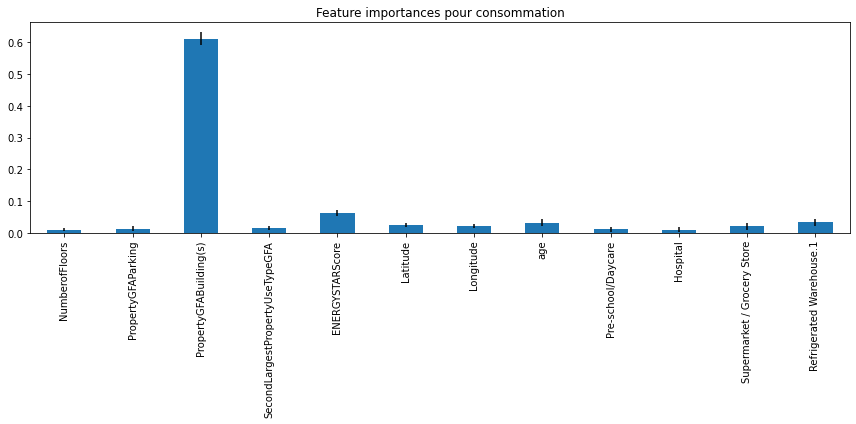

In [20]:
SEUIL = 0.01 # on définit un seuil d'importance

def show_important_features(regressor, columns, label):
    importances = []
    cols = []
    for importance, col in zip(regressor.feature_importances_, columns):
        if importance > SEUIL:
            importances.append(importance)
            cols.append(col)

    estimators_importances = []
    for estimator in regressor.estimators_:
        estimator_importances = []
        for importance, col in zip(estimator.feature_importances_, columns):
            if col in cols:
                estimator_importances.append(importance)
        estimators_importances.append(estimator_importances)
    std = np.std(estimators_importances, axis=0)

    forest_importances = pd.Series(importances, index=cols)

    fig, ax = plt.subplots(figsize=(12,6))
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances pour " + label)
    fig.tight_layout()
    
show_important_features(random_forest_regressor, X.columns, "consommation")

On constate que le nombre d'étage et les surfaces des bâtiments sont très importantes pour prédire leur consommation d'énergie, mais également l'âge du bâtiment et sa position géographique. Certains types de bâtiments semblent également déterminer la consommation.

In [21]:
xgb_regressor.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 123,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [22]:
xgb_regressor_parameters = {
    'gamma':[ 0, 0.5, 1 ],
    'learning_rate': [ .05, .1, .3 ],
    'max_depth': [ 5, 6, 7 ],
    'min_child_weight': [ 1, 5, 10 ],
    'subsample': [ 1, 2 ],
    'colsample_bytree': [ 1, 2 ],
    'n_estimators': [ 100, 500, 1000 ]
}
show_best_params_cv(xgb.XGBRegressor(random_state=123), xgb_regressor_parameters, X_train, y_train)

Nombre de combinaisons de paramètres étudiées : 972


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.74140233        nan 0.76892679        nan 0.76143964        nan
 0.74434093        nan 0.77038893        nan 0.76378148        nan
 0.74597201        nan 0.76863591        nan 0.76270531        nan
 0.74661579        nan 0.76887776        nan 0.76386466        nan
 0.74978671        nan 0.76878619        nan 0.76485597        nan
 0.75172708        nan 0.76656177        nan 0.76211032        nan
 0.74847081        nan 0.76361927        nan 0.76121718        nan
 0.75475812        nan 0.77154272        nan 0.7677677         nan
 0.75580916        nan 0.7693701         nan 0.76347664        nan
 0.7648748         nan 0.76037934        nan 0.75545582        nan
 0.76585103        nan 0.7591155         nan 0.75570153        nan
 0.76707912        nan 0.76470812        nan 0.75714966        nan
 0.76867937        nan 0.76471732        nan 0.76320611        nan

best estimator : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=7,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
best score : 0.771542723465032
best params : {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 1}

Temps de traitement total : 767.7700912952423 secondes


In [23]:
xgb_regressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=7,
             min_child_weight=5, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

fit_predict_and_show_metrics(xgb_regressor, X_train, X_test, y_train, y_test, 'XGBRegressor')

=== XGBRegressor ===
mean_absolute_error : 0.38
mean_squared_error : 0.29
root_mean_squared_error : 0.54
rmpse : 0.04
mean_absolute_percentage_error : 0.03
r2_score : 0.81
fit_time : 0.41
predict_time : 0.01



C:\anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Comparaison des scores obtenus pour chaque modèle

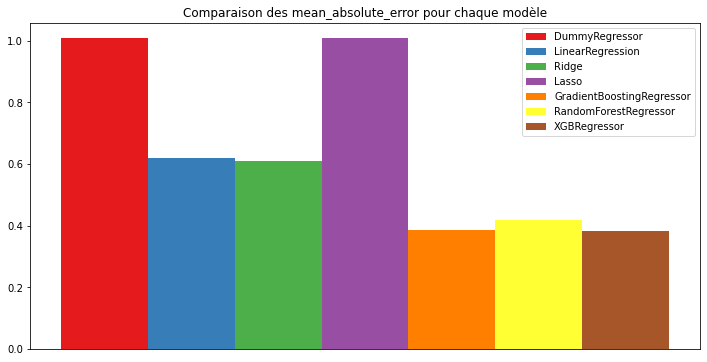

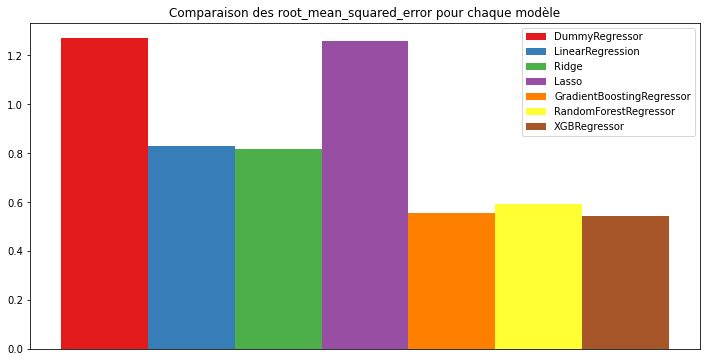

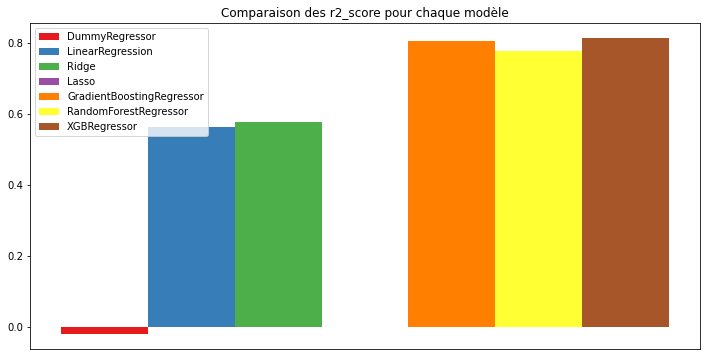

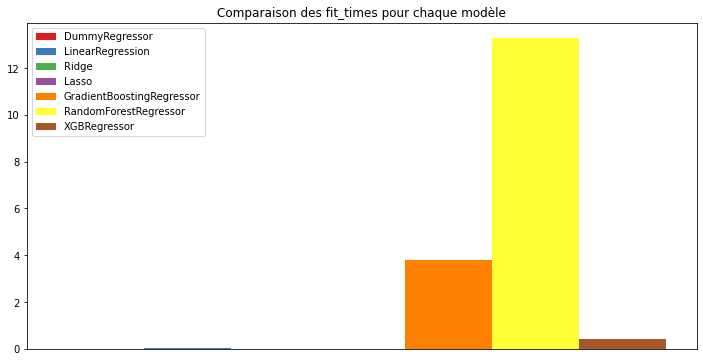

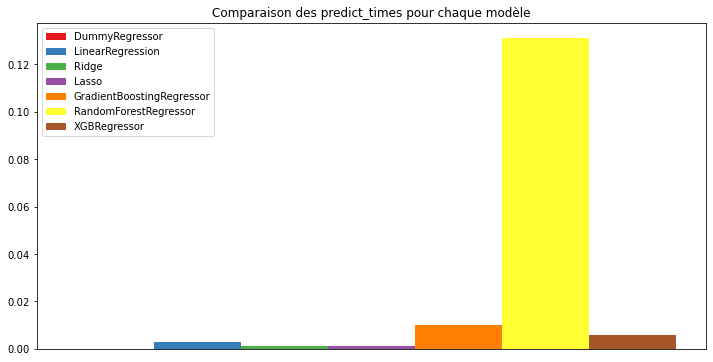

In [24]:
metrics = {
    'mean_absolute_error': mean_absolute_errors,
    'root_mean_squared_error': root_mean_squared_errors,
    'r2_score': r2_scores,
    'fit_times': fit_times,
    'predict_times': predict_times
}
width = 20
x = width * 5
for metric in metrics.keys():
    fig, ax = plt.subplots(figsize=(12,6))
    x_decalage = x - 5*width/2
    for model_name, color in zip(metrics[metric].keys(), cm.Set1.colors):
        ax.bar(x_decalage, metrics[metric][model_name], width, label=model_name, color=color)
        x_decalage = x_decalage + width
    x = x + width * 5
    ax.set_title('Comparaison des ' + metric + ' pour chaque modèle')
    ax.axes.get_xaxis().set_visible(False)
    ax.legend()
    plt.show()


On refait maintenant l'exercice avec la seconde target : les émissions de gaz à effet de serre.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y_emissions, test_size=0.2)
ct = ColumnTransformer([
        ('transformer_categ_columns', StandardScaler(), 
           ['CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 
            'PropertyGFABuilding(s)', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 
            'ENERGYSTARScore', 'Latitude', 'Longitude', 'age'])
    ], remainder='passthrough').fit(X_train)
X_train_std = ct.transform(X_train)
X_test_std = ct.transform(X_test)

mean_absolute_errors = {}
mean_squared_errors = {}
root_mean_squared_errors = {}
rmpses = {}
mean_absolute_percentage_errors = {}
r2_scores = {}
fit_times = {}
predict_times = {}

dummy_regressor = DummyRegressor(strategy="median")
fit_predict_and_show_metrics(dummy_regressor, X_train_std, X_test_std, y_train, y_test, 'DummyRegressor')
print("---")
linear_regression = LinearRegression()   
fit_predict_and_show_metrics(linear_regression, X_train, X_test, y_train, y_test, 'LinearRegression')
print("---")
ridge = Ridge(random_state=123)
fit_predict_and_show_metrics(ridge, X_train_std, X_test_std, y_train, y_test, 'Ridge')
print("---")
lasso = Lasso(random_state=123)
fit_predict_and_show_metrics(lasso, X_train_std, X_test_std, y_train, y_test, 'Lasso')

=== DummyRegressor ===
mean_absolute_error : 1.13
mean_squared_error : 2.08
root_mean_squared_error : 1.44
rmpse : 3.15
mean_absolute_percentage_error : 0.75
r2_score : -0.00
fit_time : 0.00
predict_time : 0.00

---
=== LinearRegression ===
mean_absolute_error : 0.80
mean_squared_error : 1.06
root_mean_squared_error : 1.03
rmpse : 1.99
mean_absolute_percentage_error : 0.48
r2_score : 0.49
fit_time : 0.01
predict_time : 0.00

---
=== Ridge ===
mean_absolute_error : 0.80
mean_squared_error : 1.03
root_mean_squared_error : 1.02
rmpse : 2.01
mean_absolute_percentage_error : 0.48
r2_score : 0.50
fit_time : 0.00
predict_time : 0.00

---
=== Lasso ===
mean_absolute_error : 1.13
mean_squared_error : 2.08
root_mean_squared_error : 1.44
rmpse : 3.18
mean_absolute_percentage_error : 0.75
r2_score : -0.00
fit_time : 0.00
predict_time : 0.00



In [27]:
show_best_params_cv(GradientBoostingRegressor(random_state=123), gradient_boosting_regressor_parameters, X_train, y_train)
show_best_params_cv(RandomForestRegressor(random_state=123), random_forest_parameters, X_train, y_train)
show_best_params_cv(xgb.XGBRegressor(random_state=123), xgb_regressor_parameters, X_train, y_train)

Nombre de combinaisons de paramètres étudiées : 192


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [ 3.83677307e-01  3.88114328e-01  3.81070527e-01             nan
  6.09081683e-01  6.06527838e-01  5.96934350e-01             nan
  6.35805499e-01  6.49794699e-01  6.41980368e-01             nan
  4.32051971e-01  4.48916602e-01  4.42221055e-01             nan
  6.33266907e-01  6.40852083e-01  6.34278202e-01             nan
  6.46510859e-01  6.63474695e-01  6.59125404e-01             nan
  4.70583483e-01  5.07885323e-01  4.99439292e-01             nan
  6.49609308e-01  6.59971957e-01  6.44579403e-01             nan
  6.48385180e-01  6.64577843e-01  6.52095513e-01             nan
  4.99771256e-01  5.41296753e-01  5.25887308e-01             nan
  6.53868704e-01  6.46712296e-01  5.80068465e-01             nan
  6.47958948e-01  6.44332861e-01  5.81573163e-01             nan
  6.03432010e-01  6.36279537e-01  6.43202961e-01             nan
  5.64424053e-01  6.43379

best estimator : GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000,
                          random_state=123, subsample=0.5)
best score : 0.6645778427092838
best params : {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.5}

Temps de traitement total : 180.84899616241455 secondes
Nombre de combinaisons de paramètres étudiées : 216


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.62626756 0.6259502  0.62421708
 0.62631572 0.62608091 0.62417153        nan        nan        nan
 0.6177438  0.61856217 0.61732121 0.6177438  0.61856217 0.61732121
        nan        nan        nan 0.61185235 0.61198721 0.61145078
 0.61185235 0.61198721 0.61145078        nan        nan        nan
 0.62626756 0.6259502  0.62421708 0.62631572 0.62608091 0.62417153
        nan        nan        nan 0.6177438  0.61856217 0.61732121
 0.6177438  0.61856217 0.61732121        nan        nan        nan
 0.61185235 0.61198721 0.61145078 0.61185235 0.61198721 0.61145078
        nan        nan        nan 0.62626756 0.6259502  0.62421708
 0.62631572 0.62608091 0.62417153        nan        nan        nan
 0.6177438  0.61856217 0.61732121 0.6177438  0.61856217 0.61732121
        nan        nan        nan 0.61185235 0.61198721 0.61145078

best estimator : RandomForestRegressor(min_samples_split=3, n_estimators=200, random_state=123)
best score : 0.6263157248464716
best params : {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}

Temps de traitement total : 692.174920797348 secondes
Nombre de combinaisons de paramètres étudiées : 972


C:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.64444887        nan 0.64131865        nan 0.62798318        nan
 0.64361033        nan 0.63965243        nan 0.62693362        nan
 0.63672362        nan 0.62996085        nan 0.61568542        nan
 0.63733839        nan 0.6369262         nan 0.63098507        nan
 0.64441857        nan 0.63860197        nan 0.63063896        nan
 0.63590893        nan 0.63091772        nan 0.61751424        nan
 0.6316465         nan 0.62637641        nan 0.62014095        nan
 0.63883777        nan 0.63050925        nan 0.62345851        nan
 0.62900529        nan 0.62671693        nan 0.61477585        nan
 0.64968618        nan 0.62700542        nan 0.62029412        nan
 0.64713955        nan 0.61980634        nan 0.61254101        nan
 0.64372624        nan 0.61608178        nan 0.60310713        nan
 0.63877334        nan 0.62284553        nan 0.61998415        nan

best estimator : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
best score : 0.6540370506299101
best params : {'colsample_bytree': 1, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1}

Temps de traitement total : 764.1311016082764 secondes


In [28]:
gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=500,
                          random_state=123, subsample=0.5)
fit_predict_and_show_metrics(gradient_boosting_regressor, X_train_std, X_test_std, y_train, y_test, 'GradientBoostingRegressor')
print("---")
random_forest_regressor = RandomForestRegressor(n_estimators=500, random_state=123)
fit_predict_and_show_metrics(random_forest_regressor, X_train_std, X_test_std, y_train, y_test, 'RandomForestRegressor')
print("---")
xgb_regressor = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)
fit_predict_and_show_metrics(xgb_regressor, X_train_std, X_test_std, y_train, y_test, 'XGBRegressor')

=== GradientBoostingRegressor ===
mean_absolute_error : 0.64
mean_squared_error : 0.66
root_mean_squared_error : 0.81
rmpse : 1.36
mean_absolute_percentage_error : 0.37
r2_score : 0.68
fit_time : 1.93
predict_time : 0.01

---
=== RandomForestRegressor ===
mean_absolute_error : 0.65
mean_squared_error : 0.69
root_mean_squared_error : 0.83
rmpse : 1.27
mean_absolute_percentage_error : 0.36
r2_score : 0.67
fit_time : 6.59
predict_time : 0.06

---
=== XGBRegressor ===
mean_absolute_error : 0.62
mean_squared_error : 0.64
root_mean_squared_error : 0.80
rmpse : 1.36
mean_absolute_percentage_error : 0.36
r2_score : 0.69
fit_time : 0.49
predict_time : 0.00



C:\anaconda\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


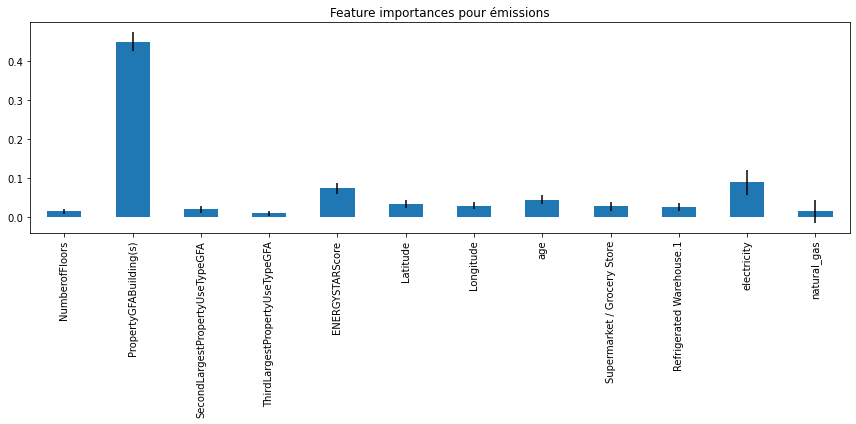

In [29]:
show_important_features(random_forest_regressor, X.columns, "émissions")

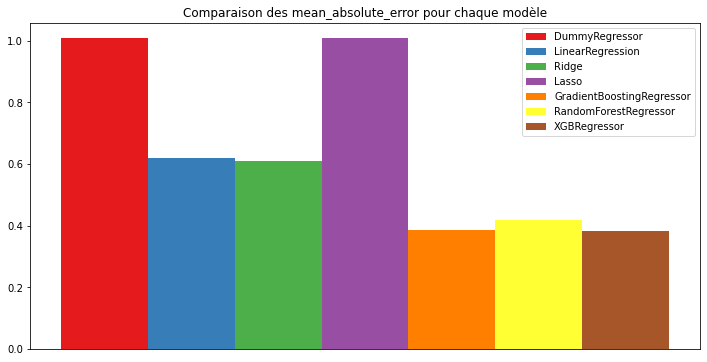

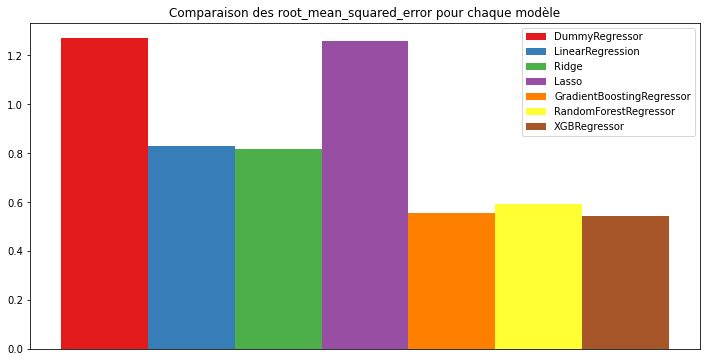

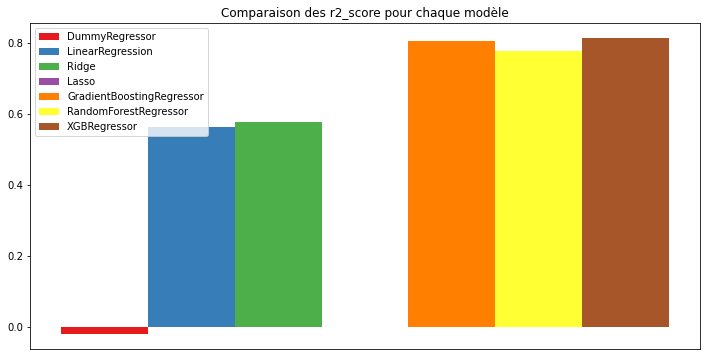

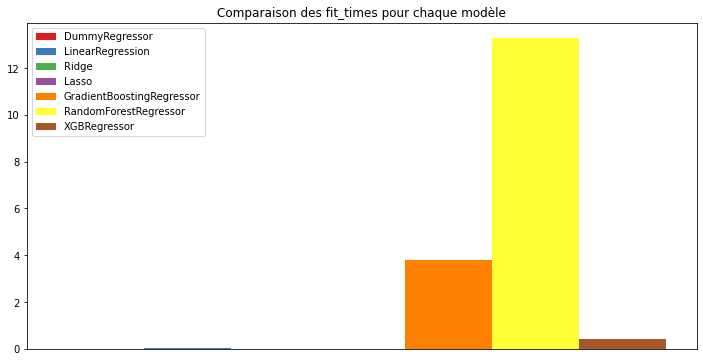

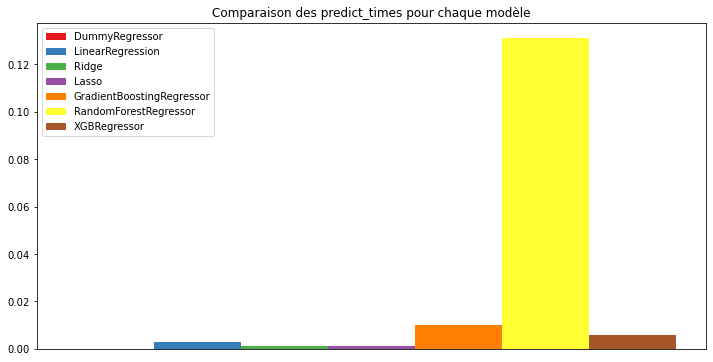

In [30]:
width = 20
x = width * 5
for metric in metrics.keys():
    fig, ax = plt.subplots(figsize=(12,6))
    x_decalage = x - 5*width/2
    for model_name, color in zip(metrics[metric].keys(), cm.Set1.colors):
        ax.bar(x_decalage, metrics[metric][model_name], width, label=model_name, color=color)
        x_decalage = x_decalage + width
    x = x + width * 5
    ax.set_title('Comparaison des ' + metric + ' pour chaque modèle')
    ax.axes.get_xaxis().set_visible(False)
    ax.legend()
    plt.show()